In [5]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision.datasets import ImageFolder
import torch.nn.functional as F
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
cuda = torch.cuda.is_available()
cuda =False
device = 'cuda' if cuda else 'cpu'
%matplotlib inline

In [6]:
# Overview of ID class names and class identifiers
class_dict = {  "Abyssinian": 0,
                "american_bulldog": 1,
                "american_pit_bull_terrier": 2,
                "basset_hound": 3,
                "beagle": 4,
                "Bengal": 5,
                "Birman": 6,
                "Bombay": 7,
                "boxer": 8,
                "British_Shorthair": 9,
                "chihuahua": 10,
                "Egyptian_Mau": 11,
                "english_cocker_spaniel": 12,
                "english_setter": 13,
                "german_shorthaired": 14,
                "great_pyrenees": 15,
                "havanese": 16,
                "japanese_chin": 17,
                "keeshond": 18,
                "leonberger": 19,
                "Maine_Coon": 20,
                "miniature_pinscher": 21,
                "newfoundland": 22,
                "Persian": 23,
                "pomeranian": 24,
                "pug": 25,
                "Ragdoll": 26,
                "Russian_Blue": 27,
                "saint_bernard": 28,
                "samoyed": 29,
                "scottish_terrier": 30,
                "shiba_inu": 31,
                "Siamese": 32,
                "Sphynx": 33,
                "staffordshire_bull_terrier": 34,
                "wheaten_terrier": 35,
                "yorkshire_terrier": 36}

In [7]:
# Import cats and dogs dataset
all_images_path = ".\cats_and_dogs\images"

import glob
from PIL import Image
from torchvision.transforms import ToTensor
import re

batch_size = 32
img_height = 224
img_width = 224

# Define transformations for ID
train_transform = transforms.Compose([
    transforms.RandomRotation(40),
    transforms.RandomResizedCrop((img_width, img_height)),
    transforms.RandomAffine(degrees=0, translate=(0.2, 0.2), shear=0.2, scale=(0.8, 1.2)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

# Define transformations for OOD
all_transform = transforms.Compose([
    transforms.Resize((img_width, img_height)),
    transforms.ToTensor(),
])

# Custom image dataset to properly load cats and dogs
#  one of the issues was naming the images and assigning them to the correct class in a weird file structure
class CustomImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []

        img_paths_bad = glob.glob(os.path.join(root_dir, '*.jpg'))  # Load only .jpg files

        img_paths = [i.replace("\\", "/") for i in img_paths_bad] # Change img path so it can be parsed

        for img_path in img_paths:
            label = os.path.splitext(os.path.basename(img_path))[0]  # Extract label from filename
            self.image_paths.append(img_path)
            self.labels.append(label)

        labs = [class_dict[re.sub(r'_\d+', '', i)] for i in self.labels]
        self.labels = labs

    def __len__(self):
        # When requesting len() this shows the size of dataset
        return len(self.image_paths)

    def __getitem__(self, idx):
        # When requesting item from the dataset, this returns the correct image, label combination
        #  This is in line with the required pytorch format of a custom dataset https://pytorch.org/tutorials/beginner/basics/data_tutorial.html
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label


dataset = CustomImageDataset(root_dir="cats_and_dogs/images", transform=all_transform)

# Random 10% of the dataset is validation dataset
n_val = int(0.1 * len(dataset))
train_dataset, val_dataset = random_split(dataset, [len(dataset) - n_val, n_val])
train_dataset.dataset.transform = train_transform

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=False)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=False)


In [8]:
# Load model. Where we transfer learned resnet18 from Imagenet1k weights to cats and dogs
from torchvision.models import resnet18, ResNet18_Weights

pretrained_resnet = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)

# Unlock layers to train all the layers instead of just the last few
for param in pretrained_resnet.parameters():
    param.requires_grad = True

# Modify the output layer to 37 
num_classes = len(class_dict.items())
pretrained_resnet.fc = nn.Linear(pretrained_resnet.fc.in_features, num_classes)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(pretrained_resnet.parameters(), lr=0.001, momentum=0.9)

#####################
# When using pre-trained weights:
#####################

# Load pre-trained weights
pretrained_resnet.load_state_dict(torch.load('catsDogs_resnet_100.pth'))
pretrained_resnet.eval()

pretrained_resnet.train()
for inputs, labels in train_loader:
    inputs, labels = inputs.to(device), labels.to(device)

    outputs = pretrained_resnet(inputs)
    loss = criterion(outputs, labels)
print(loss.item())

# Get accuracy on validation set
correct = 0
total = 0
pretrained_resnet.eval()
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = pretrained_resnet(inputs)
        # Update validation metrics if needed
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f"Accuracy on validation dataset: {100 * correct / total}%")


0.9021339416503906
Accuracy on validation dataset: 84.16779431664412%


In [9]:
# Load OOD dataset
from torch.utils.data import Subset
from PIL import Image
import glob

image_size=(224, 224)

OOD_folder_path = 'AnimalTextureOOD'

preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

ood_dataset = ImageFolder(root='AnimalTextureOOD', transform=preprocess)
OOD_Dataloader = DataLoader(ood_dataset, batch_size=32, shuffle=True)

for OOD_input_batch, ood_labels in OOD_Dataloader:
    break

# Get the classification results for OOD dataset
with torch.no_grad():
    output = pretrained_resnet(OOD_input_batch)

# Get the predicted class for each input
_, predicted = torch.max(output, 1)

# Show classification of each input to verify that not everything gets mapped to the same class
for i in range(len(predicted)):
    print(f"Input {i}: Class {predicted[i]}")

# Now it would be very interesting if this output showed everything was mapped to the same class (or few classes).
#  That is not the case so we need proper OOD detection

Input 0: Class 15
Input 1: Class 23
Input 2: Class 34
Input 3: Class 36
Input 4: Class 22
Input 5: Class 16
Input 6: Class 12
Input 7: Class 31
Input 8: Class 14
Input 9: Class 14
Input 10: Class 21
Input 11: Class 15
Input 12: Class 8
Input 13: Class 14
Input 14: Class 36
Input 15: Class 35
Input 16: Class 7
Input 17: Class 21
Input 18: Class 3
Input 19: Class 21
Input 20: Class 11
Input 21: Class 35
Input 22: Class 26
Input 23: Class 19
Input 24: Class 27
Input 25: Class 11
Input 26: Class 31
Input 27: Class 21
Input 28: Class 35
Input 29: Class 34
Input 30: Class 35
Input 31: Class 33


In [10]:
# Import nearOOD and farOOD images
nearood_dataset = ImageFolder(root='AnimalnearOOD', transform=preprocess)
farood_dataset = ImageFolder(root='TexturefarOOD', transform=preprocess)

nearOOD_Dataloader = DataLoader(nearood_dataset, batch_size=32, shuffle=True)
farOOD_Dataloader = DataLoader(farood_dataset, batch_size=32, shuffle=True)

In [7]:
def active_all_returnXY(dataloader, dataset_title: str, layer_name, use_clean_img_resnet=True, net=None):
    """
    Function that retrieves activation in a layer for an entire dataloader.
      records input and predictions for the dataloader and returns these.
    
    dataloader: data to get activation from
    dataset_title: for referencing and organizing
    layer_name: layer name to get activation from
    use_clean_img_resnet: True if use resnet with imagenet weights or False if supply model manually 
    net: if use_clean_img_resnet=False, supply model
    """
    x_list = []
    y_list = []
    if use_clean_img_resnet:
        clean_img_resnet = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
    else:
        clean_img_resnet = net

    # example; layer4.1.conv2 can't be found. Because layer4, 1 and conv2 are nested. So split and go through the list
    layer_loc_list = layer_name.split(".") 
    target_layer_found = False
    activation_measures = []

    def hook_fn(layer_name, module, input, output):
        # What to do with the activation. Energy measure uses a formula here, we just append it to a list
        activation_measures.append(output)

    hooks = []

    def traverse_model(module):
        # Recursion to iterate over model layers to find layer of interest and register hook
        #  interstingly, I thought the layers would all be consecutive but instead they are nested in blocks
        #  this is why a recursion is required because otherwise you can't reach the nested layers
        nonlocal target_layer_found
        nonlocal layer_loc_list
        for name, child_module in module.named_children():
            if name == layer_loc_list[0]:
                if len(layer_loc_list) == 1:
                    target_layer_found = True
                    hook_handle = child_module.register_forward_hook(lambda _, inp, out, ln=layer_name: hook_fn(ln, _, inp, out))
                    hooks.append(hook_handle)
                    break
                else:
                    layer_loc_list = layer_loc_list[1:]
            
                traverse_model(child_module)

    # Traverse model to establish hooks
    traverse_model(clean_img_resnet)

    if not target_layer_found:
        raise ValueError(f"Layer with name '{layer_name}' not found in the model.")

    # Forward pass data through the model
    for batch in dataloader:
        # Extract batch
        try:
            inputs, _ = batch
        except:
            inputs = batch

        x_list.append(inputs)
        
        # Forward pass
        with torch.no_grad():
            model_output = clean_img_resnet(inputs)
            y_list.append(model_output)

    for hook_handle in hooks:
        hook_handle.remove()

    return activation_measures, x_list, y_list

In [8]:
# r_pt_all_c2_far_ood_activations, r_far_x, r_far_y = active_all_returnXY(farOOD_Dataloader, "Far OOD", 'layer4.1.conv2', use_clean_img_resnet=False, net=pretrained_resnet)
# r_pt_all_c2_near_ood_activations, r_near_x, r_near_y = active_all_returnXY(nearOOD_Dataloader, "Near OOD", 'layer4.1.conv2', use_clean_img_resnet=False, net=pretrained_resnet)
# r_pt_all_c2_cd_activations, r_cd_x, r_cd_y = active_all_returnXY(train_loader, "CD", 'layer4.1.conv2', use_clean_img_resnet=False, net=pretrained_resnet)
# r_pt_all_c2_ood_activations, r_ood_x, r_ood_y = active_all_returnXY(OOD_Dataloader, "OOD", 'layer4.1.conv2', use_clean_img_resnet=False, net=pretrained_resnet)

In [19]:
import pickle

# # Save the list using pickle
# with open("actClassClf/r_pt_all_c2_far_ood_activations.pkl", 'wb') as f:
#     pickle.dump(r_pt_all_c2_far_ood_activations, f)

# with open("actClassClf/r_pt_all_c2_near_ood_activations.pkl", 'wb') as f:
#     pickle.dump(r_pt_all_c2_near_ood_activations, f)

# with open("actClassClf/r_pt_all_c2_cd_activations.pkl", 'wb') as f:
#     pickle.dump(r_pt_all_c2_cd_activations, f)

# with open("actClassClf/r_pt_all_c2_ood_activations.pkl", 'wb') as f:
#     pickle.dump(r_pt_all_c2_ood_activations, f)

# with open("actClassClf/r_far_x.pkl", 'wb') as f:
#     pickle.dump(r_far_x, f)

# with open("actClassClf/r_near_x.pkl", 'wb') as f:
#     pickle.dump(r_near_x, f)

# with open("actClassClf/r_cd_x.pkl", 'wb') as f:
#     pickle.dump(r_cd_x, f)

# with open("actClassClf/r_ood_x.pkl", 'wb') as f:
#     pickle.dump(r_ood_x, f)

# with open("actClassClf/r_far_y.pkl", 'wb') as f:
#     pickle.dump(r_far_y, f)

# with open("actClassClf/r_near_y.pkl", 'wb') as f:
#     pickle.dump(r_near_y, f)

# with open("actClassClf/r_cd_y.pkl", 'wb') as f:
#     pickle.dump(r_cd_y, f)

# with open("actClassClf/r_ood_y.pkl", 'wb') as f:
#     pickle.dump(r_ood_y, f)

# Read the objects
with open("actClassClf/r_pt_all_c2_far_ood_activations.pkl", 'rb') as f:
    r_pt_all_c2_far_ood_activations = pickle.load(f)

with open("actClassClf/r_pt_all_c2_near_ood_activations.pkl", 'rb') as f:
    r_pt_all_c2_near_ood_activations = pickle.load(f)

with open("actClassClf/r_pt_all_c2_cd_activations.pkl", 'rb') as f:
    r_pt_all_c2_cd_activations = pickle.load(f)

with open("actClassClf/r_pt_all_c2_ood_activations.pkl", 'rb') as f:
    r_pt_all_c2_ood_activations = pickle.load(f)

with open("actClassClf/r_far_x.pkl", 'rb') as f:
    r_far_x = pickle.load(f)

with open("actClassClf/r_near_x.pkl", 'rb') as f:
    r_near_x = pickle.load(f)

with open("actClassClf/r_cd_x.pkl", 'rb') as f:
    r_cd_x = pickle.load(f)

with open("actClassClf/r_ood_x.pkl", 'rb') as f:
    r_ood_x = pickle.load(f)

with open("actClassClf/r_far_y.pkl", 'rb') as f:
    r_far_y = pickle.load(f)

with open("actClassClf/r_near_y.pkl", 'rb') as f:
    r_near_y = pickle.load(f)

with open("actClassClf/r_cd_y.pkl", 'rb') as f:
    r_cd_y = pickle.load(f)

with open("actClassClf/r_ood_y.pkl", 'rb') as f:
    r_ood_y = pickle.load(f)


In [20]:
# Apply relu.

def relu(l):
    return [torch.relu(tensor) for tensor in l]

r_pt_all_c2_far_ood_activations = relu(r_pt_all_c2_far_ood_activations)
r_pt_all_c2_near_ood_activations = relu(r_pt_all_c2_near_ood_activations)
r_pt_all_c2_cd_activations = relu(r_pt_all_c2_cd_activations)
r_pt_all_c2_ood_activations = relu(r_pt_all_c2_ood_activations)

In [21]:
# We reduce our 512x7x7 activation map to (512,) by getting the maximum of the 7x7

from tqdm import tqdm
def act_to_maxfeature(act):
    maxs = list()
    for b in tqdm(act):
        for s in b:
            s_maxs = list()
            for f in s:
                s_maxs.append(f.max().item())
            maxs.append(s_maxs)
    return maxs

r_pt_all_c2_far_ood_act_max = act_to_maxfeature(r_pt_all_c2_far_ood_activations)
r_pt_all_c2_near_ood_act_max = act_to_maxfeature(r_pt_all_c2_near_ood_activations)
r_pt_all_c2_cd_act_max = act_to_maxfeature(r_pt_all_c2_cd_activations)
r_pt_all_c2_ood_act_max = act_to_maxfeature(r_pt_all_c2_ood_activations)

100%|████████████████████████████████████████████████████████████████████████████████| 182/182 [00:13<00:00, 13.79it/s]


In [101]:
# # Functions that could be used to multiply the activation map with the gradient
# #  this was a train of thought we explored to find features that are not only present but also important
# #  it ended up not working as expected.

# def flatten_y_pred(y_pred):
#     return [y for b in y_pred for y in b]

# def multiply_act_by_gradient(activation, y_pred, gradient):
#     y_pred = flatten_y_pred(y_pred)
#     C = np.zeros((len(activation), len(activation[0])))
#     for i, y in tqdm(enumerate(y_pred)):
#         C[i] = torch.from_numpy(np.array(activation[i])) * gradient[int(np.argmax(y))]
    
#     return C

# mul_r_pt_all_c2_far_ood_act_max = multiply_act_by_gradient(r_pt_all_c2_far_ood_act_max, r_far_y, pr_grad)
# mul_r_pt_all_c2_near_ood_act_max = multiply_act_by_gradient(r_pt_all_c2_near_ood_act_max, r_near_y, pr_grad)
# mul_r_pt_all_c2_cd_act_max = multiply_act_by_gradient(r_pt_all_c2_cd_act_max, r_cd_y, pr_grad)
# mul_r_pt_all_c2_ood_act_max = multiply_act_by_gradient(r_pt_all_c2_ood_act_max, r_ood_y, pr_grad)

1833it [00:00, 6380.86it/s]
3970it [00:00, 7389.87it/s]
6651it [00:00, 7356.94it/s]
5803it [00:00, 7352.04it/s]


In [22]:
from operator import itemgetter
# Get top 14 features (512/37 = ~14)

def get_k_list(l, k=14):
    m4 = list()

    for s in l:
        m4.append(np.mean(sorted(s, reverse=True)[:k]))
    return m4

# pt_all_c2_far_act_mfk = get_k_list(mul_r_pt_all_c2_far_ood_act_max)
# pt_all_c2_near_act_mfk = get_k_list(mul_r_pt_all_c2_near_ood_act_max)
# pt_all_c2_cd_act_mfk = get_k_list(mul_r_pt_all_c2_cd_act_max)
# pt_all_c2_ood_act_mfk = get_k_list(mul_r_pt_all_c2_ood_act_max)

pt_all_c2_far_act_mfk = get_k_list(r_pt_all_c2_far_ood_act_max)
pt_all_c2_near_act_mfk = get_k_list(r_pt_all_c2_near_ood_act_max)
pt_all_c2_cd_act_mfk = get_k_list(r_pt_all_c2_cd_act_max)
pt_all_c2_ood_act_mfk = get_k_list(r_pt_all_c2_ood_act_max)

In [36]:
from helpers import get_measures

def turmoil(arr):
    return np.reshape(np.array(arr), (-1, 1))

mfk_c2_auroc, mfk_c2_aupr_in, mfk_c2_aupr_out, mfk_c2_fpr95, mfk_c2_threshold = get_measures(turmoil(pt_all_c2_cd_act_mfk), turmoil(pt_all_c2_ood_act_mfk))

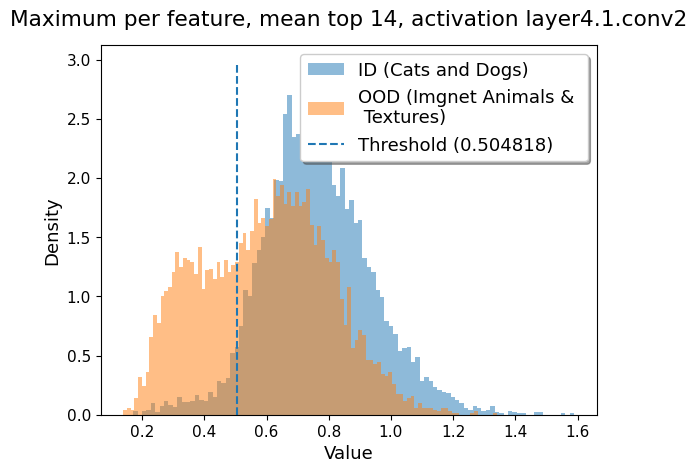

In [37]:
import matplotlib
visualizeThreshold(turmoil(pt_all_c2_cd_act_mfk), turmoil(pt_all_c2_ood_act_mfk), mfk_c2_threshold, title="Maximum per feature, mean top 14, activation layer4.1.conv2", extra_plot=False)

In [51]:
# # Get r_ood_x of
# pt_all_c2_ood_act_mfk < mfk_c2_threshold
r_OOD_x_all = [inp for b in r_ood_x for inp in b]
OOD_input_under_act_threshold = [r_OOD_x_all[inx] for inx in np.where(pt_all_c2_ood_act_mfk < mfk_c2_threshold)[0]]

# Get r_cd_x of
# pt_all_c2_cd_act_mfk < mfk_c2_threshold
r_cd_x_all = [inp for b in r_cd_x for inp in b]
cd_input_under_act_threshold = [r_cd_x_all[inx] for inx in np.where(pt_all_c2_cd_act_mfk < mfk_c2_threshold)[0]]


In [52]:
print(len(OOD_input_under_act_threshold), OOD_input_under_act_threshold[0].shape)
print(len(cd_input_under_act_threshold), cd_input_under_act_threshold[0].shape)
print(len(r_ood_x), r_ood_x[0].shape)
print(len(r_OOD_x_all), r_OOD_x_all[0].shape)

479 torch.Size([3, 224, 224])
645 torch.Size([3, 224, 224])
182 torch.Size([32, 3, 224, 224])
5803 torch.Size([3, 224, 224])


In [12]:
import pickle
# with open("actClassClf/pt_all_c2_far_act_mfk.pkl", 'wb') as f:
#     pickle.dump(pt_all_c2_far_act_mfk, f)

# with open("actClassClf/pt_all_c2_near_act_mfk.pkl", 'wb') as f:
#     pickle.dump(pt_all_c2_near_act_mfk, f)

# with open("actClassClf/pt_all_c2_cd_act_mfk.pkl", 'wb') as f:
#     pickle.dump(pt_all_c2_cd_act_mfk, f)

# with open("actClassClf/pt_all_c2_ood_act_mfk.pkl", 'wb') as f:
#     pickle.dump(pt_all_c2_ood_act_mfk, f)

with open("actClassClf/pt_all_c2_far_act_mfk.pkl", 'rb') as f:
    pt_all_c2_far_act_mfk = pickle.load(f)

with open("actClassClf/pt_all_c2_near_act_mfk.pkl", 'rb') as f:
    pt_all_c2_near_act_mfk = pickle.load(f)

with open("actClassClf/pt_all_c2_cd_act_mfk.pkl", 'rb') as f:
    pt_all_c2_cd_act_mfk = pickle.load(f)

with open("actClassClf/pt_all_c2_ood_act_mfk.pkl", 'rb') as f:
    pt_all_c2_ood_act_mfk = pickle.load(f)


In [53]:
# Create a new dataset from these inputs. Use them to generate output and compare
class CustomDataset(Dataset):
    def __init__(self, x_list, y_list):
        self.x = x_list
        self.y = y_list

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return torch.tensor(self.x[idx]), torch.tensor(self.y[idx])

# Set classes to 0 since we can omit it for now 
ood_utresh_y = np.zeros(len(OOD_input_under_act_threshold))
cd_utresh_y = np.zeros(len(cd_input_under_act_threshold))

ood_utresh_dataset = CustomDataset(OOD_input_under_act_threshold, ood_utresh_y)
cd_utresh_dataset = CustomDataset(cd_input_under_act_threshold, cd_utresh_y)

ood_utresh_dataloader = DataLoader(ood_utresh_dataset, batch_size=32, shuffle=True)
cd_utresh_dataloader = DataLoader(cd_utresh_dataset, batch_size=32, shuffle=True)

In [22]:
def get_flat_outputs(dataloader, model):
    batch_outputs = list()

    for batch in tqdm(dataloader):
        try:
            inputs, y = batch
        except:
            inputs = batch
        
        # Forward pass
        with torch.no_grad():
            model_output = model(inputs)

        # Get the predicted class for each input
        max_vals, _ = torch.max(model_output, 1)
        batch_outputs.append(max_vals)
        
    return [logit for b in batch_outputs for logit in b]

far_outputs_flat = get_flat_outputs(farOOD_Dataloader, pretrained_resnet)
near_outputs_flat = get_flat_outputs(nearOOD_Dataloader, pretrained_resnet)
cd_outputs_flat = get_flat_outputs(train_loader, pretrained_resnet)
ood_outputs_flat = get_flat_outputs(OOD_Dataloader, pretrained_resnet)
ood_uthresh_outputs_flat = get_flat_outputs(ood_utresh_dataloader, pretrained_resnet)
cd_uthresh_outputs_flat = get_flat_outputs(cd_utresh_dataloader, pretrained_resnet)

  0%|                                                                                           | 0/13 [00:00<?, ?it/s]C:\Users\Pim\AppData\Local\Temp\ipykernel_12100\3137929605.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(self.x[idx]), torch.tensor(self.y[idx])
100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:06<00:00,  1.59it/s]


In [13]:
# with open("actClassClf/far_outputs_flat.pkl", 'wb') as f:
#     pickle.dump(far_outputs_flat, f)

# with open("actClassClf/near_outputs_flat.pkl", 'wb') as f:
#     pickle.dump(near_outputs_flat, f)

# with open("actClassClf/cd_outputs_flat.pkl", 'wb') as f:
#     pickle.dump(cd_outputs_flat, f)

# with open("actClassClf/ood_outputs_flat.pkl", 'wb') as f:
#     pickle.dump(ood_outputs_flat, f)

# with open("actClassClf/ood_uthresh_outputs_flat.pkl", 'wb') as f:
#     pickle.dump(ood_uthresh_outputs_flat, f)

# with open("actClassClf/cd_uthresh_outputs_flat.pkl", 'wb') as f:
#     pickle.dump(cd_uthresh_outputs_flat, f)

with open("actClassClf/far_outputs_flat.pkl", 'rb') as f:
    far_outputs_flat = pickle.load(f)

with open("actClassClf/near_outputs_flat.pkl", 'rb') as f:
    near_outputs_flat = pickle.load(f)

with open("actClassClf/cd_outputs_flat.pkl", 'rb') as f:
    cd_outputs_flat = pickle.load(f)

with open("actClassClf/ood_outputs_flat.pkl", 'rb') as f:
    ood_outputs_flat = pickle.load(f)

with open("actClassClf/ood_uthresh_outputs_flat.pkl", 'rb') as f:
    ood_uthresh_outputs_flat = pickle.load(f)

with open("actClassClf/cd_uthresh_outputs_flat.pkl", 'rb') as f:
    cd_uthresh_outputs_flat = pickle.load(f)


In [14]:
# Visualizes 2 densities and 1 threshold

def visualizeThreshold(distID, distOOD, thresh, title, alpha=0.5, plot = True, extra_plot=True):
  matplotlib.rcParams.update({'font.size': 13,
                              'axes.labelsize': 13,
                              'xtick.labelsize': 11,
                              'ytick.labelsize': 11})
  distID = distID[np.isfinite(distID)]
  distOOD = distOOD[np.isfinite(distOOD)]

  densID, binsID, _ = plt.hist(distID, bins = 100, density = True, alpha = 0.5, label = 'ID (Cats and Dogs)')
  densOOD, binsOOD, _ = plt.hist(distOOD, bins = 100, density = True, alpha = 0.5, label = 'OOD (Imgnet Animals & \n Textures)')

  widthID = binsID[1]-binsID[0]
  widthOOD = binsOOD[1]-binsOOD[0]
  n = len(densID)

  low = np.min([binsID[0], binsOOD[0]])
  high = np.max([binsID[-1], binsOOD[-1]])
  thresholds = np.linspace(low, high, n)

  massID = np.zeros(n)
  massOOD = np.zeros(n)

  for i,x in enumerate(thresholds):
    massOOD[i] = np.sum(densOOD[binsOOD[:-1] < x]) * widthOOD
    massID[i] = np.sum(densID[binsID[:-1] >= x]) * widthID

  if plot:
    plt.vlines(thresh, 0, 1.1*np.max([densOOD, densID]), label = f'Threshold ({thresh:.6f})', linestyles = 'dashed')
    plt.xlabel('Value')
    plt.ylabel('Density')
    plt.title(title, y=1.03)
    plt.legend(fancybox=True, shadow=True)
    # plt.legend(loc='upper center', bbox_to_anchor=(0.95, 0.95), fancybox=True, shadow=True)
    plt.show()

  if extra_plot:
    plt.figure()
    plt.plot(thresholds, massID, label = 'ID mass right')
    plt.plot(thresholds, massOOD, label = 'OOD mass left')
    plt.vlines(thresh, 0, 1.1, label = f'Threshold ({thresh:.6f})', linestyles = 'dashed')
    plt.legend()
    plt.tight_layout()
    plt.show()

In [15]:
# Visualizes 3 densities and 1 threshold

def visualizeThresholdOverlay(distID, distOOD, distOverlay, thresh, title, l1, l2, l3, cov, alpha=0.5, plot = True, extra_plot=True):
  matplotlib.rcParams.update({'font.size': 13,
                              'axes.labelsize': 13,
                              'xtick.labelsize': 11,
                              'ytick.labelsize': 11})
  distID = distID[np.isfinite(distID)]
  distOOD = distOOD[np.isfinite(distOOD)]

  densID, binsID, _ = plt.hist(distID, bins = 100, density = True, alpha = 0.5, label = l1)
  densOOD, binsOOD, _ = plt.hist(distOOD, bins = 100, density = True, alpha = 0.5, label = l2)
  if cov:  
    densOverlay, binsOverlay, _ = plt.hist(distOverlay, bins = 100, density = True, alpha = 0.5, label = l3, color='red')
  else:
    densOverlay, binsOverlay, _ = plt.hist(distOverlay, bins = 100, density = True, alpha = 0.5, label = l3)

  widthID = binsID[1]-binsID[0]
  widthOOD = binsOOD[1]-binsOOD[0]
  n = len(densID)

  low = np.min([binsID[0], binsOOD[0]])
  high = np.max([binsID[-1], binsOOD[-1]])
  thresholds = np.linspace(low, high, n)

  massID = np.zeros(n)
  massOOD = np.zeros(n)

  for i,x in enumerate(thresholds):
    massOOD[i] = np.sum(densOOD[binsOOD[:-1] < x]) * widthOOD
    massID[i] = np.sum(densID[binsID[:-1] >= x]) * widthID

  if plot:
    plt.vlines(thresh, 0, 1.1*np.max([densOOD, densID, densOverlay]), label = f'Threshold ({thresh:.6f})', linestyles = 'dashed')
    plt.xlabel('Value')
    plt.ylabel('Density')
    plt.title(title, y=1.03)
    plt.legend(fancybox=True, shadow=True)
    # plt.legend(loc='upper center', bbox_to_anchor=(0.95, 0.95), fancybox=True, shadow=True)
    plt.show()

  if extra_plot:
    plt.figure()
    plt.plot(thresholds, massID, label = 'ID mass right')
    plt.plot(thresholds, massOOD, label = 'OOD mass left')
    plt.vlines(thresh, 0, 1.1, label = f'Threshold ({thresh:.6f})', linestyles = 'dashed')
    plt.legend()
    plt.tight_layout()
    plt.show()

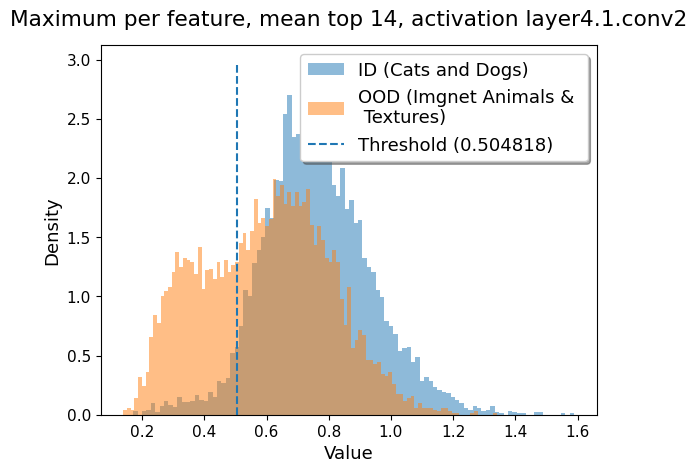

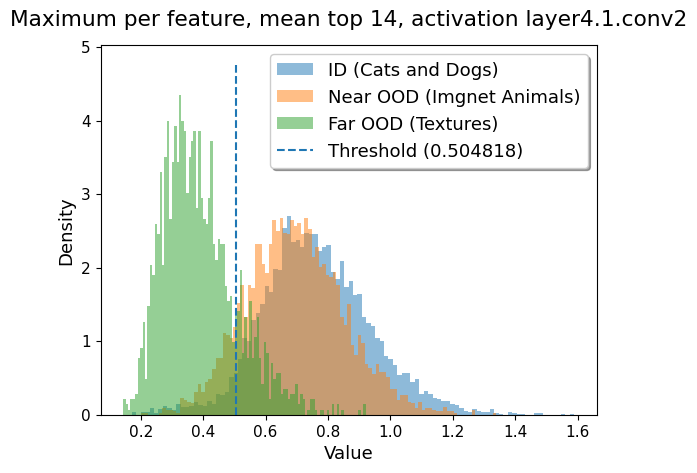

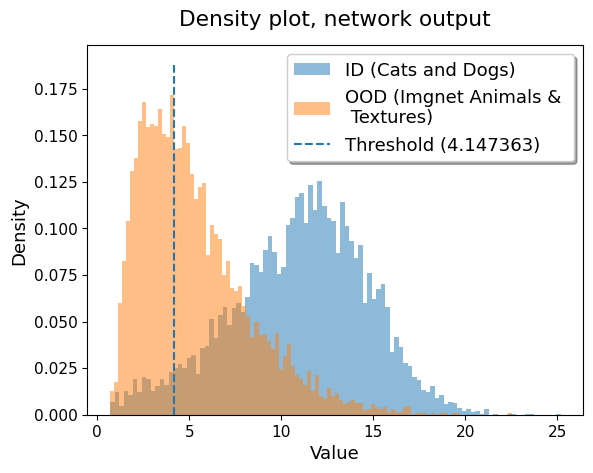

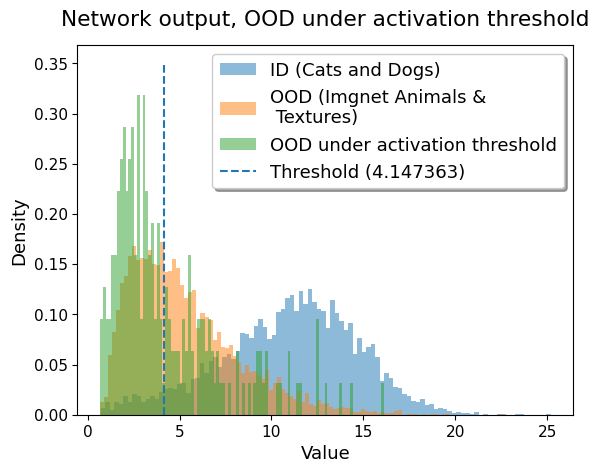

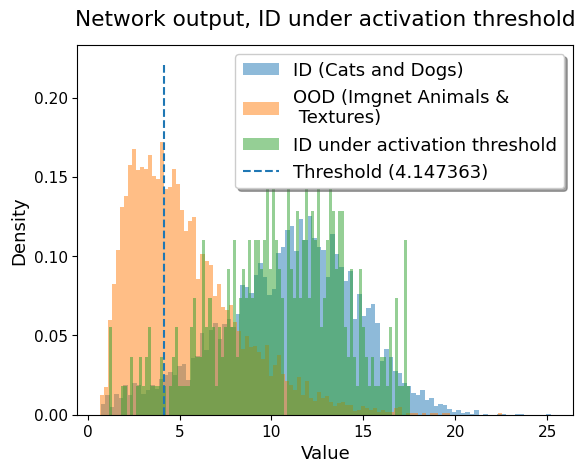

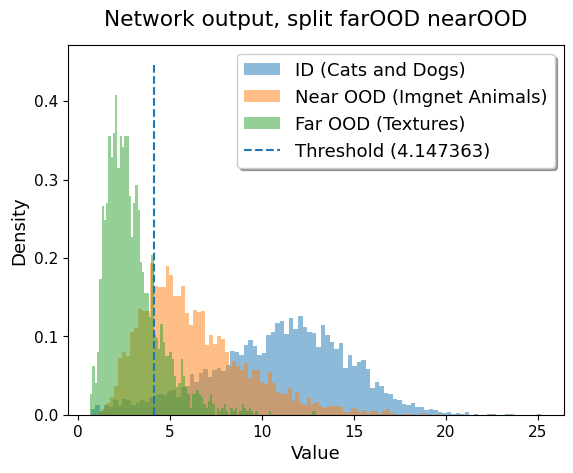

In [25]:
import matplotlib
o_auroc, o_aupr_in, o_aupr_out, o_fpr95, o_threshold = get_measures(turmoil(cd_outputs_flat), turmoil(ood_outputs_flat))

# Visualize the activation plot
visualizeThreshold(turmoil(pt_all_c2_cd_act_mfk), turmoil(pt_all_c2_ood_act_mfk), mfk_c2_threshold, title="Maximum per feature, mean top 14, activation layer4.1.conv2", extra_plot=False)
# nearOOD, farOOD
visualizeThresholdOverlay(turmoil(pt_all_c2_cd_act_mfk), turmoil(pt_all_c2_near_act_mfk), turmoil(pt_all_c2_far_act_mfk), mfk_c2_threshold, "Maximum per feature, mean top 14, activation layer4.1.conv2", 
                          l1='ID (Cats and Dogs)', l2='Near OOD (Imgnet Animals)', l3='Far OOD (Textures)', cov=False, extra_plot=False)

# Visualize the output plot
# Output
visualizeThreshold(turmoil(cd_outputs_flat), turmoil(ood_outputs_flat), o_threshold, title="Density plot, network output", extra_plot=False)
# Output OOD uthresh overlay
visualizeThresholdOverlay(turmoil(cd_outputs_flat), turmoil(ood_outputs_flat), turmoil(ood_uthresh_outputs_flat), o_threshold, 'Network output, OOD under activation threshold', 
                          l1='ID (Cats and Dogs)', l2='OOD (Imgnet Animals & \n Textures)', l3='OOD under activation threshold', cov=False, extra_plot=False)
# Output ID uthresh overlay
visualizeThresholdOverlay(turmoil(cd_outputs_flat), turmoil(ood_outputs_flat), turmoil(cd_uthresh_outputs_flat), o_threshold, 'Network output, ID under activation threshold', 
                          l1='ID (Cats and Dogs)', l2='OOD (Imgnet Animals & \n Textures)', l3='ID under activation threshold', cov=False, extra_plot=False)
# Output nearOOD, farOOD overlay
visualizeThresholdOverlay(turmoil(cd_outputs_flat), turmoil(near_outputs_flat), turmoil(far_outputs_flat), o_threshold, 'Network output, split farOOD nearOOD', 
                          l1='ID (Cats and Dogs)', l2='Near OOD (Imgnet Animals)', l3='Far OOD (Textures)', cov=False, extra_plot=False)


In [21]:
print("Output")
print(f"CD output under threshold: {len(np.where(cd_outputs_flat < o_threshold)[0])} | {round((len(np.where(cd_outputs_flat < o_threshold)[0])/len(cd_outputs_flat))*100, 4)}%")
print(f"OOD output under threshold: {len(np.where(ood_outputs_flat < o_threshold)[0])} | {round((len(np.where(ood_outputs_flat < o_threshold)[0])/len(ood_outputs_flat))*100, 4)}%")
print(f"NearOOD output under threshold: {len(np.where(near_outputs_flat < o_threshold)[0])} | {round((len(np.where(near_outputs_flat < o_threshold)[0])/len(near_outputs_flat))*100, 4)}%")
print(f"FarOOD output under threshold: {len(np.where(far_outputs_flat < o_threshold)[0])} | {round((len(np.where(far_outputs_flat < o_threshold)[0])/len(far_outputs_flat))*100, 4)}%")
print("")
print("Activation")
print(f"CD activation under threshold: {len(np.where(pt_all_c2_cd_act_mfk < mfk_c2_threshold)[0])} | {round((len(np.where(pt_all_c2_cd_act_mfk < mfk_c2_threshold)[0])/len(pt_all_c2_cd_act_mfk))*100, 4)}%")
print(f"OOD activation under threshold: {len(np.where(pt_all_c2_ood_act_mfk < mfk_c2_threshold)[0])} | {round((len(np.where(pt_all_c2_ood_act_mfk < mfk_c2_threshold)[0])/len(pt_all_c2_ood_act_mfk))*100, 4)}%")
print(f"NearOOD activation under threshold: {len(np.where(pt_all_c2_near_act_mfk < mfk_c2_threshold)[0])} | {round((len(np.where(pt_all_c2_near_act_mfk < mfk_c2_threshold)[0])/len(pt_all_c2_near_act_mfk))*100, 4)}%")
print(f"FarOOD activation under threshold: {len(np.where(pt_all_c2_far_act_mfk < mfk_c2_threshold)[0])} | {round((len(np.where(pt_all_c2_far_act_mfk < mfk_c2_threshold)[0])/len(pt_all_c2_far_act_mfk))*100, 4)}%")


Output
CD output under threshold: 333 | 5.0068%
OOD output under threshold: 2479 | 42.7193%
NearOOD output under threshold: 968 | 24.3829%
FarOOD output under threshold: 1511 | 82.4332%

Activation
CD activation under threshold: 333 | 5.0068%
OOD activation under threshold: 1981 | 34.1375%
NearOOD activation under threshold: 426 | 10.7305%
FarOOD activation under threshold: 1528 | 83.3606%


In [26]:
## Idea: OOD if under threshold activation OR under threshold of output
AindicesOODuthresh = np.where(pt_all_c2_ood_act_mfk < mfk_c2_threshold)[0]
OindicesOODuthresh = np.where(ood_outputs_flat < o_threshold)[0]
UindicesOODuthresh = list(set(AindicesOODuthresh).union(set(OindicesOODuthresh)))

print("OOD".rjust(61))
print(f"OOD activation under threshold: {len(AindicesOODuthresh)} | {round((len(AindicesOODuthresh)/len(pt_all_c2_ood_act_mfk))*100, 4)}%".rjust(61))
print(f"OOD output under threshold: {len(OindicesOODuthresh)} | {round((len(OindicesOODuthresh)/len(ood_outputs_flat))*100, 4)}%".rjust(61))
print(f"OOD activation or output under threshold: {len(UindicesOODuthresh)} | {round((len(UindicesOODuthresh)/len(pt_all_c2_ood_act_mfk))*100, 4)}%".rjust(61))
print("")

NAindicesOODuthresh = np.where(pt_all_c2_near_act_mfk < mfk_c2_threshold)[0]
NOindicesOODuthresh = np.where(near_outputs_flat < o_threshold)[0]
NUindicesOODuthresh = list(set(NAindicesOODuthresh).union(set(NOindicesOODuthresh)))

print("NearOOD".rjust(61))
print(f"NearOOD activation under threshold: {len(NAindicesOODuthresh)} | {round((len(NAindicesOODuthresh)/len(pt_all_c2_near_act_mfk))*100, 4)}%".rjust(61))
print(f"NearOOD output under threshold: {len(NOindicesOODuthresh)} | {round((len(NOindicesOODuthresh)/len(near_outputs_flat))*100, 4)}%".rjust(61))
print(f"NearOOD activation or output under threshold: {len(NUindicesOODuthresh)} | {round((len(NUindicesOODuthresh)/len(pt_all_c2_near_act_mfk))*100, 4)}%".rjust(61))
print("")

FAindicesOODuthresh = np.where(pt_all_c2_far_act_mfk < mfk_c2_threshold)[0]
FOindicesOODuthresh = np.where(far_outputs_flat < o_threshold)[0]
FUindicesOODuthresh = list(set(FAindicesOODuthresh).union(set(FOindicesOODuthresh)))

print("FarOOD".rjust(61))
print(f"FarOOD activation under threshold: {len(FAindicesOODuthresh)} | {round((len(FAindicesOODuthresh)/len(pt_all_c2_far_act_mfk))*100, 4)}%".rjust(61))
print(f"FarOOD output under threshold: {len(FOindicesOODuthresh)} | {round((len(FOindicesOODuthresh)/len(far_outputs_flat))*100, 4)}%".rjust(61))
print(f"FarOOD activation or output under threshold: {len(FUindicesOODuthresh)} | {round((len(FUindicesOODuthresh)/len(pt_all_c2_far_act_mfk))*100, 4)}0%".rjust(61))
print("")

IAindicesOODuthresh = np.where(pt_all_c2_cd_act_mfk < mfk_c2_threshold)[0]
IOindicesOODuthresh = np.where(cd_outputs_flat < o_threshold)[0]
IUindicesOODuthresh = list(set(IAindicesOODuthresh).union(set(IOindicesOODuthresh)))

# While it improves OOD detection, the FNR is now almost twice as big.
#  Thresholds should be adjusted to ensure TPR = 95%
print("ID".rjust(61))
print(f"ID activation under threshold: {len(IAindicesOODuthresh)} | {round((len(IAindicesOODuthresh)/len(pt_all_c2_cd_act_mfk))*100, 4)}%".rjust(61))
print(f"ID output under threshold: {len(IOindicesOODuthresh)} | {round((len(IOindicesOODuthresh)/len(cd_outputs_flat))*100, 4)}%".rjust(61))
print(f"ID activation or output under threshold: {len(IUindicesOODuthresh)} | {round((len(IUindicesOODuthresh)/len(pt_all_c2_cd_act_mfk))*100, 4)}%".rjust(61))



                                                          OOD
              OOD activation under threshold: 1981 | 34.1375%
                  OOD output under threshold: 2479 | 42.7193%
    OOD activation or output under threshold: 3620 | 62.3815%

                                                      NearOOD
           NearOOD activation under threshold: 426 | 10.7305%
               NearOOD output under threshold: 968 | 24.3829%
NearOOD activation or output under threshold: 1304 | 32.8463%

                                                       FarOOD
           FarOOD activation under threshold: 1528 | 83.3606%
               FarOOD output under threshold: 1511 | 82.4332%
FarOOD activation or output under threshold: 1774 | 96.78120%

                                                           ID
                 ID activation under threshold: 333 | 5.0068%
                     ID output under threshold: 333 | 5.0068%
       ID activation or output under threshold: 649 | 9.7579%


### Idea: Combine output and activation measure
- Get thresholds for every .5% tpr. For both output and activation
- Combine output and activation and check when TPR = 95.

In [79]:
def get_m_levels(id, ood):
    recall_levels, aurocs, aupr_ins, aupr_outs, fpr95s, thresholds = list(), list(), list(), list(), list(), list()
    for recall_l in tqdm(np.linspace(0.95, 1, 26)):
        m = get_measures(turmoil(id), turmoil(ood), recall_l)
        recall_levels.append(recall_l)
        aurocs.append(m[0])
        aupr_ins.append(m[1])
        aupr_outs.append(m[2])
        fpr95s.append(m[3])
        thresholds.append(m[4])

    return [recall_levels, aurocs, aupr_ins, aupr_outs, fpr95s, thresholds]
        
act_measures = get_m_levels(pt_all_c2_cd_act_mfk, pt_all_c2_ood_act_mfk)
output_measures = get_m_levels(cd_outputs_flat, ood_outputs_flat)

100%|██████████████████████████████████████████████████████████████████████████████████| 26/26 [00:02<00:00, 11.65it/s]


In [80]:
import itertools
def combine_results(act_m, out_m):
    thresh_m, tnr_m, tpr_m = list(), list(), list()
    for inx, t in tqdm(enumerate(itertools.product(*[act_m[5], out_m[5]]))):
        AindicesOOD = np.where(pt_all_c2_ood_act_mfk < t[0])[0]
        OindicesOOD = np.where(ood_outputs_flat < t[1])[0]
        UindicesOOD = list(set(AindicesOOD).union(set(OindicesOOD)))

        AindicesCD = np.where(pt_all_c2_cd_act_mfk < t[0])[0]
        OindicesCD = np.where(cd_outputs_flat < t[1])[0]
        UindicesCD = list(set(AindicesCD).union(set(OindicesCD)))

        thresh_m.append(t)
        tnr_m.append(len(UindicesOOD)/len(pt_all_c2_ood_act_mfk))
        tpr_m.append(len(UindicesCD)/len(pt_all_c2_cd_act_mfk))

    return [thresh_m, tpr_m, tnr_m]

combo_results = combine_results(act_measures, output_measures)

676it [00:54, 12.29it/s]


In [82]:
def find_best_combo(combo_results, desired_tpr=0.95):
    closest_value = min(combo_results[1], key=lambda x:abs(x-(1-desired_tpr)))
    best_thresh, best_tnr = None, 0
    
    for inx, _ in enumerate(combo_results[1]):
        if combo_results[1][inx] == closest_value:
            if combo_results[2][inx] > best_tnr:
                best_thresh = combo_results[0][inx]
                best_tnr = combo_results[2][inx]

    return best_thresh, closest_value, best_tnr

opt_comb_thresh, opt_tpr, opt_fpr = find_best_combo(combo_results)

In [84]:
opt_comb_thresh

(0.17113130912184715, 4.1473627)

In [83]:
UindicesOODopt = list(set(np.where(pt_all_c2_ood_act_mfk < opt_comb_thresh[0])[0]).union(set(np.where(ood_outputs_flat < opt_comb_thresh[1])[0])))
UindicesNearopt = list(set(np.where(pt_all_c2_near_act_mfk < opt_comb_thresh[0])[0]).union(set(np.where(near_outputs_flat < opt_comb_thresh[1])[0])))
UindicesFaropt = list(set(np.where(pt_all_c2_far_act_mfk < opt_comb_thresh[0])[0]).union(set(np.where(far_outputs_flat < opt_comb_thresh[1])[0])))
UindicesCDopt = list(set(np.where(pt_all_c2_cd_act_mfk < opt_comb_thresh[0])[0]).union(set(np.where(cd_outputs_flat < opt_comb_thresh[1])[0])))

print("Combined output and activation".rjust(61))
print(f"OOD activation or output under threshold: {len(UindicesOODopt)} | {round((len(UindicesOODopt)/len(pt_all_c2_ood_act_mfk))*100, 4)}%".rjust(61))
print(f"NearOOD activation or output under threshold:  {len(UindicesNearopt)} | {round((len(UindicesNearopt)/len(pt_all_c2_near_act_mfk))*100, 4)}%".rjust(61))
print(f"FarOOD activation or output under threshold: {len(UindicesFaropt)} | {round((len(UindicesFaropt)/len(pt_all_c2_far_act_mfk))*100, 4)}%".rjust(61))
print(f"CD activation or output under threshold:  {len(UindicesCDopt)} |  {round((len(UindicesCDopt)/len(pt_all_c2_cd_act_mfk))*100, 4)}%".rjust(61))



                               Combined output and activation
    OOD activation or output under threshold: 2487 | 42.8571%
NearOOD activation or output under threshold:  968 | 24.3829%
 FarOOD activation or output under threshold: 1512 | 82.4877%
     CD activation or output under threshold:  333 |  5.0068%


### Sum output and activation

In [88]:
def plus_act_out(act, out):
    combi = list()
    for inx, i in enumerate(act):
        combi.append(i + out[inx].item())
    
    return combi

ao_ood = plus_act_out(pt_all_c2_ood_act_mfk, ood_outputs_flat)
ao_near = plus_act_out(pt_all_c2_near_act_mfk, near_outputs_flat)
ao_far = plus_act_out(pt_all_c2_far_act_mfk, far_outputs_flat)
ao_cd = plus_act_out(pt_all_c2_cd_act_mfk, cd_outputs_flat)

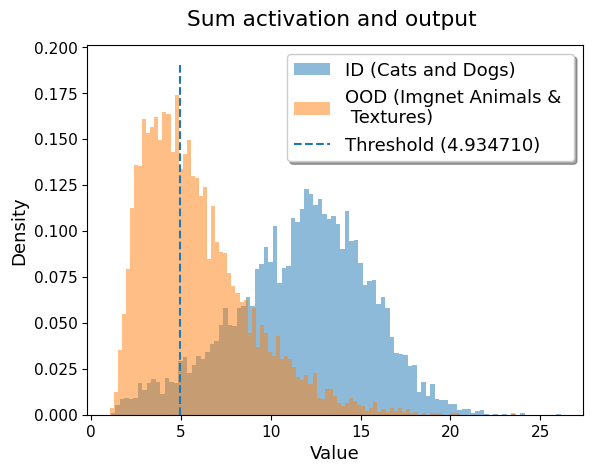

0.5419610546269171


In [91]:
ao_auroc, ao_aupr_in, ao_aupr_out, ao_fpr95, ao_threshold = get_measures(turmoil(ao_cd), turmoil(ao_ood))

visualizeThreshold(turmoil(ao_cd), turmoil(ao_ood), ao_threshold, title="Sum activation and output ", extra_plot=False)
print(ao_fpr95)

In [98]:
indicesAOood = np.where(ao_ood < ao_threshold)[0]
indicesAOnear = np.where(ao_near < ao_threshold)[0]
indicesAOfar = np.where(ao_far < ao_threshold)[0]
indicesAOcd = np.where(ao_cd < ao_threshold)[0]

print("Sum output and activation".rjust(67))
print(f"OOD sum activation and output under threshold: {len(indicesAOood)} | {round((len(indicesAOood)/len(pt_all_c2_ood_act_mfk))*100, 4)}%".rjust(67))
print(f"NearOOD sum activation and output under threshold: {len(indicesAOnear)} | {round((len(indicesAOnear)/len(pt_all_c2_near_act_mfk))*100, 4)}%".rjust(67))
print(f"FarOOD sum activation and output under threshold: {len(indicesAOfar)} | {round((len(indicesAOfar)/len(pt_all_c2_far_act_mfk))*100, 4)}%".rjust(67))
print(f"CD sum activation and output under threshold:  {len(indicesAOcd)} |  {round((len(indicesAOcd)/len(pt_all_c2_cd_act_mfk))*100, 4)}%".rjust(67))


                                          Sum output and activation
     OOD sum activation and output under threshold: 2658 | 45.8039%
 NearOOD sum activation and output under threshold: 1042 | 26.2469%
  FarOOD sum activation and output under threshold: 1578 | 86.0884%
      CD sum activation and output under threshold:  333 |  5.0068%


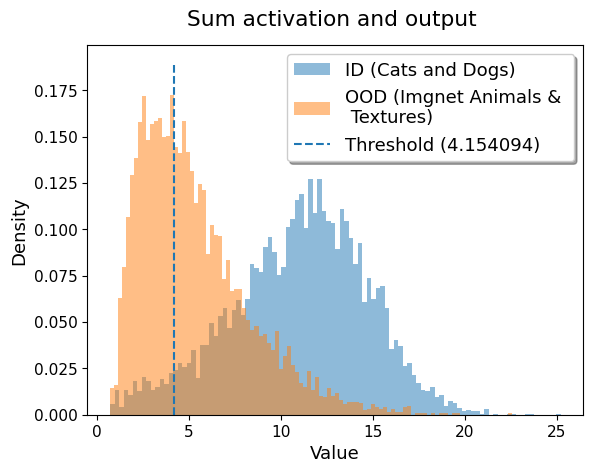

0.5736687920041358
                                          Sum output and activation
     OOD sum activation and output under threshold: 2474 | 42.6331%
 NearOOD sum activation and output under threshold:  967 | 24.3577%
  FarOOD sum activation and output under threshold: 1511 | 82.4332%
      CD sum activation and output under threshold:  333 |  5.0068%


In [107]:
ra = get_k_list(mul_r_pt_all_c2_ood_act_max)
rb = get_k_list(mul_r_pt_all_c2_near_ood_act_max)
rc = get_k_list(mul_r_pt_all_c2_far_ood_act_max)
rd = get_k_list(mul_r_pt_all_c2_cd_act_max)

gao_ood = plus_act_out(ra, ood_outputs_flat)
gao_near = plus_act_out(rb, near_outputs_flat)
gao_far = plus_act_out(rc, far_outputs_flat)
gao_cd = plus_act_out(rd, cd_outputs_flat)

gao_auroc, gao_aupr_in, gao_aupr_out, gao_fpr95, gao_threshold = get_measures(turmoil(gao_cd), turmoil(gao_ood))

visualizeThreshold(turmoil(gao_cd), turmoil(gao_ood), gao_threshold, title="Sum activation and output ", extra_plot=False)
print(gao_fpr95)

gindicesAOood = np.where(gao_ood < gao_threshold)[0]
gindicesAOnear = np.where(gao_near < gao_threshold)[0]
gindicesAOfar = np.where(gao_far < gao_threshold)[0]
gindicesAOcd = np.where(gao_cd < gao_threshold)[0]

print("Sum output and activation".rjust(67))
print(f"OOD sum activation and output under threshold: {len(gindicesAOood)} | {round((len(gindicesAOood)/len(pt_all_c2_ood_act_mfk))*100, 4)}%".rjust(67))
print(f"NearOOD sum activation and output under threshold:  {len(gindicesAOnear)} | {round((len(gindicesAOnear)/len(pt_all_c2_near_act_mfk))*100, 4)}%".rjust(67))
print(f"FarOOD sum activation and output under threshold: {len(gindicesAOfar)} | {round((len(gindicesAOfar)/len(pt_all_c2_far_act_mfk))*100, 4)}%".rjust(67))
print(f"CD sum activation and output under threshold:  {len(gindicesAOcd)} |  {round((len(gindicesAOcd)/len(pt_all_c2_cd_act_mfk))*100, 4)}%".rjust(67))


#### Generate some numbers for the report

In [113]:
sum(p.numel() for p in pretrained_resnet.parameters() if p.requires_grad)

11195493

In [114]:
from torchvision.models import vgg16, VGG16_Weights

pretrained_vgg = vgg16(weights=VGG16_Weights.IMAGENET1K_V1)

# Unlock layers
for param in pretrained_vgg.parameters():
    param.requires_grad = True

# Modify the output layer for the number of classes in your catsDogs dataset
num_classes = len(class_dict.items())
pretrained_vgg.add_module(module=nn.Linear(list(pretrained_vgg.children())[-1][-1].in_features, 75), name='fc')
pretrained_vgg.fc = nn.Linear(pretrained_vgg.fc.in_features, num_classes)

sum(p.numel() for p in pretrained_vgg.parameters() if p.requires_grad)

138509133

In [115]:
num_classes

37